<a href="https://colab.research.google.com/github/Nayan-Bebale/DeepLearningForComputerVision/blob/main/Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malaria Detection

## Import Libraries

In [4]:
1+1

2

In [40]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from google.colab import drive

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (InputLayer, Conv2D, MaxPool2D,
                                     Flatten, Dense, BatchNormalization, Resizing, Rescaling, GlobalAveragePooling2D,
                                    Activation, Dropout, Input, Layer)
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

In [6]:
main_dataset, dataset_info = tfds.load("malaria", with_info=True, shuffle_files=True, split=['train'])

## Task Understanding

In [7]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/root/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasit

In [8]:
print(main_dataset)

for data in main_dataset[0].take(1):
  print(data)

[<_PrefetchDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>]
{'image': <tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
       

## Data Prepration

In [9]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

dataset = tf.data.Dataset.range(10)
print(list(dataset.as_numpy_iterator()))
DATASET_SIZE = len(dataset)

train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
print(list(train_dataset.as_numpy_iterator()))

val_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
val_dataset = val_dataset.take(int(VAL_RATIO*DATASET_SIZE))
print(list(val_dataset.as_numpy_iterator()))

test_dataset = val_dataset.skip(int(TEST_RATIO*DATASET_SIZE))
print(list(test_dataset.as_numpy_iterator()))


[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
[np.int64(6), np.int64(7)]
[]


In [10]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

dataset = tf.data.Dataset.range(10)
print(list(dataset.as_numpy_iterator()))
DATASET_SIZE = len(dataset)

train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))
print(list(train_dataset.as_numpy_iterator()))

val_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
val_dataset = val_dataset.take(int(VAL_RATIO*DATASET_SIZE))
print(list(val_dataset.as_numpy_iterator()))

test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
test_dataset = test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
print(list(test_dataset.as_numpy_iterator()))


[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
[np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
[np.int64(6), np.int64(7)]
[np.int64(8), np.int64(9)]


In [11]:
def splits(dataset, TRAIN_RATIO, TEST_RATIO, VAL_RATIO):
  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  test_dataset = test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [12]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# dataset = tf.data.Dataset.range(10)

train_dataset, val_dataset, test_dataset = splits(main_dataset[0], TRAIN_RATIO,
                                                  TEST_RATIO, VAL_RATIO)

print(list(train_dataset.take(1).as_numpy_iterator()))
print(list(test_dataset.take(1).as_numpy_iterator()))
print(list(val_dataset.take(1).as_numpy_iterator()))

[{'image': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 'label': np.int64(1)}]
[{'image': array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
      

## Data Visualization

In [13]:
def preprocess(example):
    return example["image"], example["label"]

train_dataset = train_dataset.map(preprocess)
val_dataset   = val_dataset.map(preprocess)
test_dataset  = test_dataset.map(preprocess)


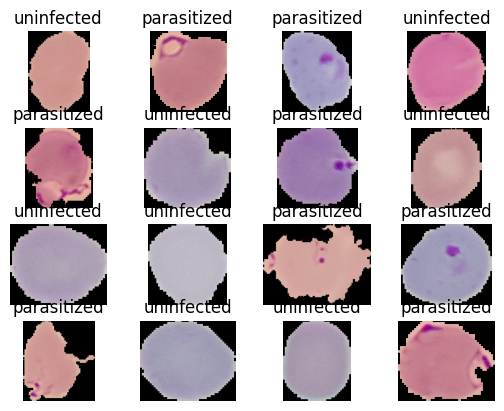

In [14]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)

  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

## Data Preprocessing

In [15]:
dataset_info.features['label'].int2str(1)

'uninfected'

In [16]:
IM_SIZE = 224
def resizing_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [17]:
train_dataset = train_dataset.map(resizing_rescale)

In [18]:
test_dataset = test_dataset.map(resizing_rescale)

In [19]:
val_dataset = val_dataset.map(resizing_rescale)

In [20]:
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [21]:
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

In [22]:
test_dataset = test_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(32).prefetch(tf.data.AUTOTUNE)

## How and Why Convents work

# How (and why) convolutions work in CNNs — deep dive (using your image’s numbers)

<img src="https://raw.githubusercontent.com/Nayan-Bebale/DeepLearningForComputerVision/refs/heads/main/CNN.png" alt="CNN Workflow image" width=800>

 It shows a typical small CNN block: an input image → conv (5×5, no padding) → downsample (pool/stride-2) → conv (5×5) → downsample → flatten → FC.

---

## 1) What a convolution layer actually does (intuitively & precisely)

* A convolution layer applies a set of **learnable filters (kernels)** that *slide* over the input spatially and compute dot-products at every spatial location.
* Each filter has spatial size $F\times F$ and spans **all input channels** (if input has $C_{in}$ channels the kernel is $F\times F\times C_{in}$).
* Each filter produces one **feature map** (also called an activation map). If you have $N_f$ filters you get an output with depth $N_f$.
* After the convolution (dot-product), we usually add one scalar bias per filter and pass the result through a nonlinearity (ReLU, etc.).
* The filter weights are shared across spatial locations → **parameter sharing**. This gives translation **equivariance** (features detected anywhere) and dramatically fewer parameters than a dense layer.

---

## 2) The output-size formulas and where they come from

Two commonly shown formulas:

$$
X_{out} \;=\; \left\lfloor\frac{X_{in} - F + 2P}{S}\right\rfloor + 1
\qquad\text{(general: padding \(P\), stride \(S\))}
$$

If no padding ($P=0$) you can write:

$$
X_{out} \;=\; \left\lfloor\frac{X_{in} - F}{S}\right\rfloor + 1
$$

**Derivation idea (1D intuition):**
A kernel of length $F$ placed on an input of length $X_{in}$ covers indices from position $p$ to $p+F-1$. The first valid top-left placement is at $p=0$, the last valid placement is when $p+F-1=X_{in}-1+P$ (padding effectively extends the input by $2P$). With step size $S$, the number of placements is $\lfloor ((X_{in}+2P)-F)/S\rfloor +1$. Same logic applies independently to height and width.

**Important notes:**

* The formula must yield an integer; typical choices (F odd, appropriate P, S dividing things) ensure that.
* Two named special cases:

  * **Valid** convolution: $P=0$ — output shrinks.
  * **Same** convolution (when $S=1$): choose $P=\frac{F-1}{2}$ (for odd $F$) so $X_{out}=X_{in}$.

You can rearrange to solve for padding $P$ when you want a specific $X_{out}$:

$$
P \;=\; \frac{S(X_{out}-1) - X_{in} + F}{2}
$$

---

## 3) Why convolutions are good (three key properties)

1. **Sparsity of interactions / local connectivity**: filters look at local patches (edges, textures) — reduces parameters and focuses on local structure.
2. **Parameter sharing**: same filter used everywhere → fewer parameters and translational equivariance.
3. **Compositional / hierarchical features**: early layers learn edges, middle layers textures, deeper layers object parts — stacking makes receptive fields grow so neurons "see" larger context.

---

## 4) Parameter count for conv layers (how many learnable numbers?)

For a conv layer with $F\times F$ filters, $C_{in}$ input channels, $N_f$ output filters:

* Weights per filter = $F \times F \times C_{in}$.
* Add 1 bias per filter.
* Total parameters $N_p = N_f \times (F\times F \times C_{in} + 1)$.

I’ll show this with the exact numbers from the image.

---

## 5) Walk-through the example in your image (step-by-step, with arithmetic)

**Input:** $64 \times 64 \times 3$

### Layer A — Conv1

* Filter size $F=5$, stride $S=1$, padding $P=0$, $N_f = 6$ filters.

* Output spatial size (width or height):

  $$
  X_{out} = \frac{64 - 5 + 2\cdot 0}{1} + 1 = 64 - 5 + 1 = 60.
  $$

  So output is $60 \times 60 \times 6$.

* Parameters:

  * Weights per filter = $5\times 5 \times 3$. Compute: $5\times 5 = 25$. Then $25 \times 3 = 75$.
  * Add bias $+1$ → $75 + 1 = 76$ parameters per filter.
  * Total $N_p = 6 \times 76 = 456$. (Matches the slide: **456**.)

### Next — Pooling / Downsample (2×2, stride 2)

* Typical pattern: after conv you often apply 2×2 max-pooling with stride 2 (or use conv with stride 2).
* Spatial dims halve: $60 \to 30$. So now we have $30 \times 30 \times 6$.

### Layer B — Conv2

* Filter $F=5$, $S=1$, $P=0$, $N_f = 16$, input channels $C_{in}=6$.

* Spatial output:

  $$
  X_{out} = \frac{30 - 5 + 2\cdot 0}{1} + 1 = 30 - 5 + 1 = 26.
  $$

  So output $26 \times 26 \times 16$.

* Parameters:

  * Weights per filter = $5\times 5 \times 6$. Compute: $25 \times 6 = 150$.
  * Add bias $+1$ → $150 + 1 = 151$.
  * Total $N_p = 16 \times 151 = 2{,}416$. (Matches the slide: **2416**.)

### Next — Pool 2×2 stride 2

* Spatial dims $26 \to 13$. Output becomes $13 \times 13 \times 16$.

### Flatten → FC

* Flattened size = $13 \times 13 \times 16$.

  * Compute $13 \times 13 = 169$.
  * Then $169 \times 16 = 169 \times 10 + 169 \times 6 = 1690 + 1014 = 2704$. (Slide shows **2704**.)
* Then fully-connected to 1000 neurons, then to 200 (example classifier head).

So the slide’s chain and numbers all follow directly from the output-size formula and the parameter-count formula.

---

## 6) Receptive field — how much of the original image a neuron ‘sees’?

Each layer increases the receptive field (RF) of neurons. Use these recurrence rules:

* Let $r_0 = 1$ (a pixel sees itself initially) and $j_0 = 1$ (jump between adjacent neuron centers).
* For layer $l$ with kernel size $k_l$ and stride $s_l$:

  * $r_l = r_{l-1} + (k_l - 1)\cdot j_{l-1}$
  * $j_l = j_{l-1} \cdot s_l$

Compute for the slide's block:

1. Conv1: $k_1=5, s_1=1$
   $r_1 = 1 + (5-1)\cdot1 = 1 + 4 = 5,\quad j_1 = 1$.
2. Pool (2×2, s=2): $k_2=2, s_2=2$
   $r_2 = 5 + (2-1)\cdot1 = 5 + 1 = 6,\quad j_2 = 1\cdot 2 = 2$.
3. Conv2 (5×5, s=1):
   $r_3 = 6 + (5-1)\cdot 2 = 6 + 8 = 14,\quad j_3 = 2$.
4. Pool (2×2, s=2):
   $r_4 = 14 + (2-1)\cdot 2 = 14 + 2 = 16,\quad j_4 = 4$.

So a neuron after the second pool has receptive field $16\times16$ in the original image — that explains how deeper neurons combine wider spatial context.

---

## 7) Practical tips & common confusions

* Use **odd-sized filters** (3×3, 5×5) so `same` padding is symmetric: $P=(F-1)/2$.
* `Same` convolution with $S=1$: $X_{out} = X_{in}$ when $P=(F-1)/2$.
* When you want to reduce spatial size, you can either:

  * use **pooling** (2×2) or
  * use **stride > 1** in the convolution (e.g., $S=2$). Strided conv both reduces size and learns filters.
* **Dilated convolutions** increase receptive field without extra parameters by inserting holes — useful when you want large RF but keep resolution.
* **Transpose convolutions / upsampling** reverse the size-reduction (used in decoders / segmentation) — their size formulas are related but slightly different.

---

## 8) Backprop — how filters get learned (brief)

* The forward pass computes dot-products between kernel weights and input patches. During backprop, gradients flow to those weights (parameter sharing means the same weight gets gradients accumulated from all spatial locations). Optimizers (SGD, Adam) update filters so they respond to discriminative patterns.

---

## Summary (one-liner)

Convolutions compute local dot-products with shared filters to produce feature maps; the output spatial size is given by $\displaystyle X_{out}=\left\lfloor\frac{X_{in}-F+2P}{S}\right\rfloor+1$, parameter count is $N_f(F^2C_{in}+1)$, and stacking convs+pooling grows receptive fields to learn hierarchical features — which is why CNNs are efficient and powerful for vision.

## How it's work

![sliding_window_stride1](https://raw.githubusercontent.com/Nayan-Bebale/DeepLearningForComputerVision/refs/heads/main/sliding_window_stride1.gif)
![sliding_window_stride2](https://raw.githubusercontent.com/Nayan-Bebale/DeepLearningForComputerVision/refs/heads/main/sliding_window_stride2.gif)




## Building ConVnets with Tensorflow

In [28]:
model = tf.keras.Sequential([
    InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),

    # Conv1: no activation here, apply BN then ReLU
    Conv2D(filters=6, kernel_size=5, strides=1, padding='valid', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=2, strides=2),

    # Conv2
    Conv2D(filters=16, kernel_size=5, strides=1, padding='valid', use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    MaxPool2D(pool_size=2, strides=2),

    GlobalAveragePooling2D(),   # replaces big Flatten + FC
    Dense(128, use_bias=False),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.4),

    Dense(1, activation='sigmoid')   # <-- important: sigmoid for binary BCE
])

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 220, 220, 6)    │           450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 220, 220, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 220, 220, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 110, 110, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 106, 106, 16)   │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 106, 106, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 106, 106, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 53, 53, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,627 (21.98 KB)

 Trainable params: 5,327 (20.81 KB)

 Non-trainable params: 300 (1.17 KB)

## Binary Crossentropy Loss

In [29]:
# --- compile with lower lr ---
opt = Adam(learning_rate=1e-3)   # start here; reduce if still unstable
model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(),   # outputs are probabilities
              metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])



In [30]:
# --- callbacks ---
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
]


## Training Convnets

In [32]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20, callbacks=callbacks)

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6691 - auc: 0.7254 - loss: 0.6198
Epoch 1: val_loss improved from inf to 0.58571, saving model to best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 54s 65ms/step - accuracy: 0.6692 - auc: 0.7256 - loss: 0.6196 - val_accuracy: 0.6515 - val_auc: 0.9480 - val_loss: 0.5857 - learning_rate: 0.0010
Epoch 2/20
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9086 - auc: 0.9624 - loss: 0.2482
Epoch 2: val_loss did not improve from 0.58571
689/689 ━━━━━━━━━━━━━━━━━━━━ 38s 55ms/step - accuracy: 0.9086 - auc: 0.9624 - loss: 0.2482 - val_accuracy: 0.5564 - val_auc: 0.8932 - val_loss: 1.3282 - learning_rate: 0.0010
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9260 - auc: 0.9721 - loss: 0.2069
Epoch 3: val_loss improved from 0.58571 to 0.46672, saving model to best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 44s 59ms/step - accuracy: 0.9260 - auc: 0.9721 - loss: 0.2069 - val_accuracy: 0.7303 - val_auc: 0.9526 - val_loss: 0.4667 - learning_rate: 0.0010
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9309 - auc: 0.9757 - loss: 0.1932
Epoch 4: val_loss did not improve from 0.46672
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.9309 - auc: 0.9757 - loss: 0.1932 - val_accuracy: 0.5702 - val_auc: 0.8988 - val_loss: 0.9613 - learning_rate: 0.0010
Epoch 5/20
687/689 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9355 - auc: 0.9768 - loss: 0.1883
Epoch 5: val_loss did not improve from 0.46672
689/689 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.9355 - auc: 0.9768 - loss: 0.1883 - val_accuracy: 0.6319 - val_auc: 0.9260 - val_loss: 0.6743 - learning_rate: 0.0010
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9349 - auc: 0.9779 - loss: 0.1830
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

E

689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 52ms/step - accuracy: 0.9406 - auc: 0.9804 - loss: 0.1716 - val_accuracy: 0.9296 - val_auc: 0.9835 - val_loss: 0.2128 - learning_rate: 5.0000e-04
Epoch 8/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9427 - auc: 0.9798 - loss: 0.1713
Epoch 8: val_loss improved from 0.21279 to 0.18064, saving model to best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.9427 - auc: 0.9798 - loss: 0.1713 - val_accuracy: 0.9397 - val_auc: 0.9814 - val_loss: 0.1806 - learning_rate: 5.0000e-04
Epoch 9/20
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9407 - auc: 0.9804 - loss: 0.1695
Epoch 9: val_loss did not improve from 0.18064
689/689 ━━━━━━━━━━━━━━━━━━━━ 37s 54ms/step - accuracy: 0.9407 - auc: 0.9804 - loss: 0.1695 - val_accuracy: 0.9100 - val_auc: 0.9827 - val_loss: 0.2654 - learning_rate: 5.0000e-04
Epoch 10/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9426 - auc: 0.9801 - loss: 0.1698
Epoch 10: val_loss improved from 0.18064 to 0.15502, saving model to best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 39s 56ms/step - accuracy: 0.9426 - auc: 0.9801 - loss: 0.1699 - val_accuracy: 0.9532 - val_auc: 0.9836 - val_loss: 0.1550 - learning_rate: 5.0000e-04
Epoch 11/20
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9424 - auc: 0.9800 - loss: 0.1700
Epoch 11: val_loss did not improve from 0.15502
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.9423 - auc: 0.9800 - loss: 0.1700 - val_accuracy: 0.9466 - val_auc: 0.9828 - val_loss: 0.1668 - learning_rate: 5.0000e-04
Epoch 12/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9455 - auc: 0.9811 - loss: 0.1635
Epoch 12: val_loss did not improve from 0.15502
689/689 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - accuracy: 0.9455 - auc: 0.9811 - loss: 0.1635 - val_accuracy: 0.9525 - val_auc: 0.9849 - val_loss: 0.1592 - learning_rate: 5.0000e-04
Epoch 13/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9448 - auc: 0.9820 - loss: 0.1612
Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00025

689/689 ━━━━━━━━━━━━━━━━━━━━ 37s 53ms/step - accuracy: 0.9475 - auc: 0.9833 - loss: 0.1542 - val_accuracy: 0.9583 - val_auc: 0.9862 - val_loss: 0.1453 - learning_rate: 2.5000e-04
Epoch 15/20
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9464 - auc: 0.9833 - loss: 0.1540
Epoch 15: val_loss improved from 0.14535 to 0.14071, saving model to best_model.h5


689/689 ━━━━━━━━━━━━━━━━━━━━ 51s 68ms/step - accuracy: 0.9464 - auc: 0.9833 - loss: 0.1540 - val_accuracy: 0.9528 - val_auc: 0.9867 - val_loss: 0.1407 - learning_rate: 2.5000e-04
Epoch 16/20
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9482 - auc: 0.9835 - loss: 0.1527
Epoch 16: val_loss did not improve from 0.14071
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.9482 - auc: 0.9835 - loss: 0.1528 - val_accuracy: 0.9514 - val_auc: 0.9866 - val_loss: 0.1439 - learning_rate: 2.5000e-04
Epoch 17/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9481 - auc: 0.9834 - loss: 0.1525
Epoch 17: val_loss did not improve from 0.14071
689/689 ━━━━━━━━━━━━━━━━━━━━ 43s 56ms/step - accuracy: 0.9481 - auc: 0.9834 - loss: 0.1525 - val_accuracy: 0.9597 - val_auc: 0.9874 - val_loss: 0.1435 - learning_rate: 2.5000e-04
Epoch 18/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.9488 - auc: 0.9836 - loss: 0.1526
Epoch 18: val_loss improved from 0.14071 to 0.13489, saving m

689/689 ━━━━━━━━━━━━━━━━━━━━ 37s 54ms/step - accuracy: 0.9488 - auc: 0.9836 - loss: 0.1526 - val_accuracy: 0.9550 - val_auc: 0.9873 - val_loss: 0.1349 - learning_rate: 2.5000e-04
Epoch 19/20
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9486 - auc: 0.9837 - loss: 0.1515
Epoch 19: val_loss did not improve from 0.13489
689/689 ━━━━━━━━━━━━━━━━━━━━ 36s 53ms/step - accuracy: 0.9486 - auc: 0.9837 - loss: 0.1515 - val_accuracy: 0.9528 - val_auc: 0.9873 - val_loss: 0.1449 - learning_rate: 2.5000e-04
Epoch 20/20
688/689 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.9496 - auc: 0.9847 - loss: 0.1476
Epoch 20: val_loss did not improve from 0.13489
689/689 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - accuracy: 0.9496 - auc: 0.9847 - loss: 0.1476 - val_accuracy: 0.9517 - val_auc: 0.9867 - val_loss: 0.1443 - learning_rate: 2.5000e-04
Restoring model weights from the end of the best epoch: 18.


## Model Visualization

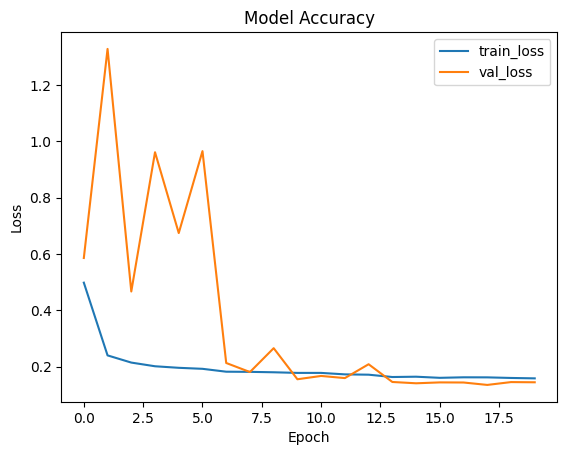

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

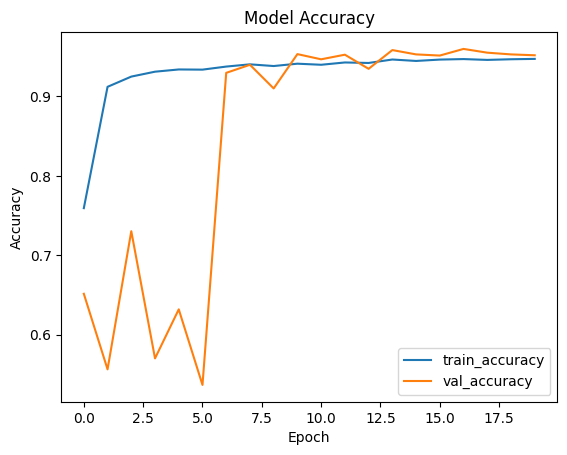

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [35]:
model.evaluate(test_dataset)

87/87 ━━━━━━━━━━━━━━━━━━━━ 14s 43ms/step - accuracy: 0.9576 - auc: 0.9846 - loss: 0.1419


[0.1467263549566269, 0.9535727500915527, 0.9842122793197632]

In [36]:
def parasite_or_not(x):
    if x<0.5:
        return str('P')
    else:
        return str('U')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


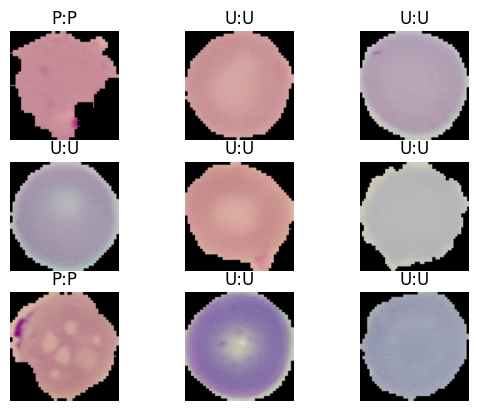

In [37]:
for i, (image, label) in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image[0])
    plt.title(str(parasite_or_not(label.numpy()[0])) + ":" + str(parasite_or_not(model.predict(image)[0][0])))
    plt.axis('off')

## Saving to and Loading from Google Drive

In [45]:
model.save("/content/lenet_model.keras")

In [41]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [46]:
!cp -r /content/lenet_model.keras /content/drive/MyDrive/DeepLearning_For_Computer_Vision/lenet/